In [1]:
import numpy as np
import random
import math
import os
import scipy.io
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
%matplotlib inline

from math import sqrt
from datetime import datetime
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [2]:
# 转换时间格式，将字符串转换成 datatime 格式
def convert_to_time(hmm):
    year, month, day, hour, minute, second = int(hmm[0]), int(hmm[1]), int(hmm[2]), int(hmm[3]), int(hmm[4]), int(hmm[5])
    return datetime(year=year, month=month, day=day, hour=hour, minute=minute, second=second)


# 加载 mat 文件
def loadMat(matfile):
    data = scipy.io.loadmat(matfile)
    filename = matfile.split('/')[-1].split('.')[0]
    col = data[filename]
    col = col[0][0][0][0]
    size = col.shape[0]

    data = []
    for i in range(size):
        k = list(col[i][3][0].dtype.fields.keys())
        d1, d2 = {}, {}
        if str(col[i][0][0]) != 'impedance':
            for j in range(len(k)):
                t = col[i][3][0][0][j][0];
                l = [t[m] for m in range(len(t))]
                d2[k[j]] = l
        d1['type'], d1['temp'], d1['time'], d1['data'] = str(col[i][0][0]), int(col[i][1][0]), str(convert_to_time(col[i][2][0])), d2
        data.append(d1)

    return data


# 提取锂电池容量
def getBatteryCapacity(Battery):
    cycle, capacity = [], []
    i = 1
    for Bat in Battery:
        if Bat['type'] == 'discharge':
            capacity.append(Bat['data']['Capacity'][0])
            cycle.append(i)
            i += 1
    return [cycle, capacity]


# 获取锂电池充电或放电时的测试数据
def getBatteryValues(Battery, Type='charge'):
    data=[]
    for Bat in Battery:
        if Bat['type'] == Type:
            data.append(Bat['data'])
    return data

In [3]:
Battery_list = ['B0005', 'B0006', 'B0007', 'B0018']
dir_path = 'dataset/'

Battery = {}
for name in Battery_list:
    print('Load Dataset ' + name + '.mat ...')
    path = dir_path + name + '.mat'
    data = loadMat(path)
    Battery[name] = getBatteryCapacity(data)              # 放电时的容量数据

Load Dataset B0005.mat ...
Load Dataset B0006.mat ...
Load Dataset B0007.mat ...
Load Dataset B0018.mat ...


### 如果上面的数据集读取失败，可以通过下面的方式加载已提取出来的数据

In [3]:
Battery_list = ['B0005', 'B0006', 'B0007', 'B0018'] # 4 个数据集的名字
Battery = np.load('dataset/NASA.npy', allow_pickle=True)
Battery = Battery.item()

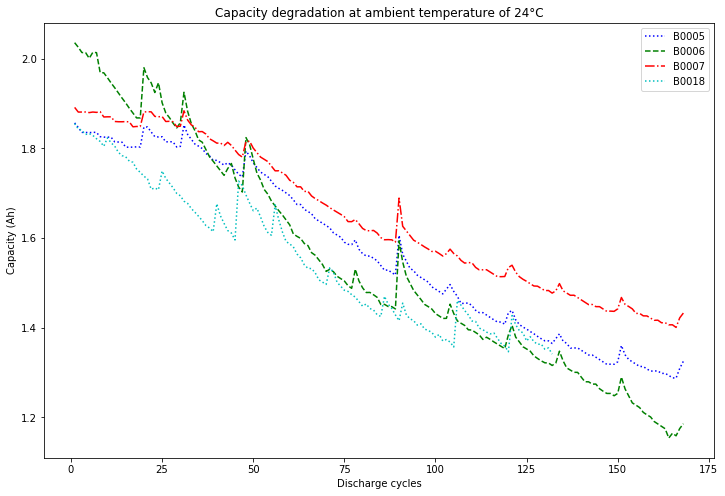

In [4]:
fig, ax = plt.subplots(1, figsize=(12, 8))
color_list = ['b:', 'g--', 'r-.', 'c:']
c = 0
for name,color in zip(Battery_list, color_list):
    df_result = Battery[name]
    ax.plot(df_result[0], df_result[1], color, label=name)
ax.set(xlabel='Discharge cycles', ylabel='Capacity (Ah)', title='Capacity degradation at ambient temperature of 24°C')
plt.legend()

In [5]:
def build_sequences(text, window_size):
    #text:list of capacity
    x, y = [],[]
    for i in range(len(text) - window_size):
        sequence = text[i:i+window_size]
        target = text[i+1:i+1+window_size]

        x.append(sequence)
        y.append(target)
        
    return np.array(x), np.array(y)


# 留一评估：一组数据为测试集，其他所有数据全部拿来训练
def get_train_test(data_dict, name, window_size=8, train_ratio=0.):
    data_sequence=data_dict[name][1]
    train_data, test_data = data_sequence[:window_size+1], data_sequence[window_size+1:]
    train_x, train_y = build_sequences(text=train_data, window_size=window_size)
    for k, v in data_dict.items():
        if k != name:
            data_x, data_y = build_sequences(text=v[1], window_size=window_size)
            train_x, train_y = np.r_[train_x, data_x], np.r_[train_y, data_y]
            
    return train_x, train_y, list(train_data), list(test_data)


def evaluation(y_test, y_predict):
    mae = mean_absolute_error(y_test, y_predict)
    mse = mean_squared_error(y_test, y_predict)
    rmse = sqrt(mean_squared_error(y_test, y_predict))
    return mae, rmse
    

def relative_error(y_test, y_predict, threshold):
    true_re, pred_re = len(y_test), 0
    for i in range(len(y_test)-1):
        if y_test[i] <= threshold >= y_test[i+1]:
            true_re = i - 1
            break
    for i in range(len(y_predict)-1):
        if y_predict[i] <= threshold:
            pred_re = i - 1
            break
    return abs(true_re - pred_re)/true_re

    
def setup_seed(seed):
    np.random.seed(seed)  # Numpy module.
    random.seed(seed)  # Python random module.
    os.environ['PYTHONHASHSEED'] = str(seed) # 为了禁止hash随机化，使得实验可复现。
    torch.manual_seed(seed) # 为CPU设置随机种子
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed) # 为当前GPU设置随机种子
        torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU，为所有GPU设置随机种子
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

In [6]:
class Net(nn.Module):
    def __init__(self, feature_size=8, hidden_size=[16, 8]):
        super(Net, self).__init__()
        self.feature_size, self.hidden_size = feature_size, hidden_size
        self.layer0 = nn.Linear(self.feature_size, self.hidden_size[0])
        self.layers = [nn.Sequential(nn.Linear(self.hidden_size[i], self.hidden_size[i+1]), nn.ReLU()) 
                       for i in range(len(self.hidden_size) - 1)]
        self.linear = nn.Linear(self.hidden_size[-1], 1)
 
    def forward(self, x):
        out = self.layer0(x)
        for layer in self.layers:
            out = layer(out)
        out = self.linear(out) 
        return out

# 留一评估

In [7]:
def tain(LR=0.01, feature_size=8, hidden_size=[16,8], weight_decay=0.0, window_size=8, EPOCH=1000, seed=0):
    mae_list, rmse_list, re_list = [], [], []
    result_list = []
    for i in range(4):
        name = Battery_list[i]
        train_x, train_y, train_data, test_data = get_train_test(Battery, name, window_size)
        train_size = len(train_x)
        print('sample size: {}'.format(train_size))

        setup_seed(seed)
        model = Net(feature_size=feature_size, hidden_size=hidden_size)
        model = model.to(device)

        optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=weight_decay)
        criterion = nn.MSELoss()

        test_x = train_data.copy()
        loss_list, y_ = [0], []
        for epoch in range(EPOCH):
            X = np.reshape(train_x/Rated_Capacity, (-1, feature_size)).astype(np.float32)
            y = np.reshape(train_y[:,-1]/Rated_Capacity,(-1,1)).astype(np.float32)

            X, y = torch.from_numpy(X).to(device), torch.from_numpy(y).to(device)
            output= model(X)
            loss = criterion(output, y)
            optimizer.zero_grad()              # clear gradients for this training step
            loss.backward()                    # backpropagation, compute gradients
            optimizer.step()                   # apply gradients

            if (epoch + 1)%100 == 0:
                test_x = train_data.copy() #每100次重新预测一次
                point_list = []
                while (len(test_x) - len(train_data)) < len(test_data):
                    x = np.reshape(np.array(test_x[-feature_size:])/Rated_Capacity, (-1, feature_size)).astype(np.float32)
                    x = torch.from_numpy(x).to(device)
                    pred = model(x) # 测试集 模型预测#pred shape为(batch_size=1, feature_size=1)
                    next_point = pred.data.numpy()[0,0] * Rated_Capacity
                    test_x.append(next_point)#测试值加入原来序列用来继续预测下一个点
                    point_list.append(next_point)#保存输出序列最后一个点的预测值
                y_.append(point_list)#保存本次预测所有的预测值
                loss_list.append(loss)
                mae, rmse = evaluation(y_test=test_data, y_predict=y_[-1])
                re = relative_error(
                    y_test=test_data, y_predict=y_[-1], threshold=Rated_Capacity*0.7)
                print('epoch:{:<2d} | loss:{:<6.4f} | MAE:{:<6.4f} | RMSE:{:<6.4f} | RE:{:<6.4f}'.format(epoch, loss, mae, rmse, re))
            if (len(loss_list) > 1) and (abs(loss_list[-2] - loss_list[-1]) < 1e-5):
                break

        mae, rmse = evaluation(y_test=test_data, y_predict=y_[-1])
        re = relative_error(y_test=test_data, y_predict=y_[-1], threshold=Rated_Capacity*0.7)
        mae_list.append(mae)
        rmse_list.append(rmse)
        re_list.append(re)
        result_list.append(y_[-1])
    return re_list, mae_list, rmse_list, result_list

# 设置 10 个不同的随机种子，然后取均值。

In [8]:
window_size = 8
EPOCH = 1000
LR = 0.01    # learning rate
feature_size = window_size
hidden_size = [16,8]
weight_decay = 0.0
Rated_Capacity = 2.0

MAE, RMSE, RE = [], [], []
for seed in range(10):
    re_list, mae_list, rmse_list, _ = tain(LR, feature_size, hidden_size, 
                                           weight_decay, window_size, EPOCH, seed)
    RE.append(np.mean(np.array(re_list)))
    MAE.append(np.mean(np.array(mae_list)))
    RMSE.append(np.mean(np.array(rmse_list)))
    print('------------------------------------------------------------------')

print('RE: mean: {:<6.4f} | std: {:<6.4f}'.format(np.mean(np.array(RE)), np.std(np.array(RE))))
print('MAE: mean: {:<6.4f} | std: {:<6.4f}'.format(np.mean(np.array(MAE)), np.std(np.array(MAE))))
print('RMSE: mean: {:<6.4f} | std: {:<6.4f}'.format(np.mean(np.array(RMSE)), np.std(np.array(RMSE))))
print('------------------------------------------------------------------')
print('------------------------------------------------------------------')

sample size: 445
epoch:99 | loss:0.0003 | MAE:0.1028 | RMSE:0.1163 | RE:1.0000
epoch:199 | loss:0.0003 | MAE:0.0959 | RMSE:0.1093 | RE:1.0000
epoch:299 | loss:0.0003 | MAE:0.0867 | RMSE:0.1003 | RE:1.0000
epoch:399 | loss:0.0002 | MAE:0.0769 | RMSE:0.0910 | RE:0.1140
epoch:499 | loss:0.0002 | MAE:0.0676 | RMSE:0.0830 | RE:0.0088
epoch:599 | loss:0.0002 | MAE:0.0608 | RMSE:0.0771 | RE:0.0614
sample size: 445
epoch:99 | loss:0.0002 | MAE:0.1258 | RMSE:0.1537 | RE:1.0000
epoch:199 | loss:0.0002 | MAE:0.1143 | RMSE:0.1402 | RE:1.0000
epoch:299 | loss:0.0002 | MAE:0.1090 | RMSE:0.1335 | RE:1.0000
epoch:399 | loss:0.0002 | MAE:0.1051 | RMSE:0.1282 | RE:1.0000
epoch:499 | loss:0.0002 | MAE:0.1050 | RMSE:0.1261 | RE:1.0000
epoch:599 | loss:0.0001 | MAE:0.1091 | RMSE:0.1282 | RE:1.0000
epoch:699 | loss:0.0001 | MAE:0.1157 | RMSE:0.1331 | RE:1.0000
sample size: 445
epoch:99 | loss:0.0003 | MAE:0.1064 | RMSE:0.1273 | RE:1.0000
epoch:199 | loss:0.0003 | MAE:0.1191 | RMSE:0.1356 | RE:1.0000
epoch:2

sample size: 445
epoch:99 | loss:0.0012 | MAE:0.1234 | RMSE:0.1489 | RE:1.0000
epoch:199 | loss:0.0009 | MAE:0.1266 | RMSE:0.1554 | RE:1.0000
epoch:299 | loss:0.0006 | MAE:0.1237 | RMSE:0.1514 | RE:1.0000
epoch:399 | loss:0.0004 | MAE:0.1200 | RMSE:0.1462 | RE:1.0000
epoch:499 | loss:0.0003 | MAE:0.1173 | RMSE:0.1405 | RE:1.0000
epoch:599 | loss:0.0002 | MAE:0.1202 | RMSE:0.1356 | RE:0.0566
epoch:699 | loss:0.0002 | MAE:0.1249 | RMSE:0.1322 | RE:0.3082
epoch:799 | loss:0.0002 | MAE:0.1260 | RMSE:0.1298 | RE:0.3459
epoch:899 | loss:0.0002 | MAE:0.1245 | RMSE:0.1278 | RE:0.3522
sample size: 481
epoch:99 | loss:0.0012 | MAE:0.1125 | RMSE:0.1282 | RE:1.0000
epoch:199 | loss:0.0009 | MAE:0.1018 | RMSE:0.1130 | RE:1.0000
epoch:299 | loss:0.0006 | MAE:0.0923 | RMSE:0.1034 | RE:1.0000
epoch:399 | loss:0.0004 | MAE:0.0796 | RMSE:0.0904 | RE:1.0000
epoch:499 | loss:0.0003 | MAE:0.0643 | RMSE:0.0747 | RE:1.0000
epoch:599 | loss:0.0002 | MAE:0.0488 | RMSE:0.0588 | RE:1.0000
epoch:699 | loss:0.0002

epoch:899 | loss:0.0001 | MAE:0.0347 | RMSE:0.0420 | RE:0.2442
------------------------------------------------------------------
sample size: 445
epoch:99 | loss:0.0002 | MAE:0.0702 | RMSE:0.0805 | RE:1.0000
epoch:199 | loss:0.0001 | MAE:0.0573 | RMSE:0.0724 | RE:0.0789
epoch:299 | loss:0.0001 | MAE:0.0581 | RMSE:0.0710 | RE:0.0877
sample size: 445
epoch:99 | loss:0.0001 | MAE:0.2101 | RMSE:0.2374 | RE:1.0000
epoch:199 | loss:0.0001 | MAE:0.1241 | RMSE:0.1406 | RE:1.0000
epoch:299 | loss:0.0001 | MAE:0.1296 | RMSE:0.1456 | RE:1.0000
sample size: 445
epoch:99 | loss:0.0002 | MAE:0.0393 | RMSE:0.0507 | RE:1.0000
epoch:199 | loss:0.0001 | MAE:0.1226 | RMSE:0.1260 | RE:0.3459
epoch:299 | loss:0.0001 | MAE:0.1217 | RMSE:0.1254 | RE:0.3459
sample size: 481
epoch:99 | loss:0.0001 | MAE:0.0923 | RMSE:0.1059 | RE:1.0000
epoch:199 | loss:0.0001 | MAE:0.0331 | RMSE:0.0403 | RE:0.2674
epoch:299 | loss:0.0001 | MAE:0.0336 | RMSE:0.0409 | RE:0.2442
--------------------------------------------------

# 查看每组电池的曲线拟合效果

sample size: 445
epoch:99 | loss:0.0003 | MAE:0.1028 | RMSE:0.1163 | RE:1.0000
epoch:199 | loss:0.0003 | MAE:0.0959 | RMSE:0.1093 | RE:1.0000
epoch:299 | loss:0.0003 | MAE:0.0867 | RMSE:0.1003 | RE:1.0000
epoch:399 | loss:0.0002 | MAE:0.0769 | RMSE:0.0910 | RE:0.1140
epoch:499 | loss:0.0002 | MAE:0.0676 | RMSE:0.0830 | RE:0.0088
epoch:599 | loss:0.0002 | MAE:0.0608 | RMSE:0.0771 | RE:0.0614
sample size: 445
epoch:99 | loss:0.0002 | MAE:0.1258 | RMSE:0.1537 | RE:1.0000
epoch:199 | loss:0.0002 | MAE:0.1143 | RMSE:0.1402 | RE:1.0000
epoch:299 | loss:0.0002 | MAE:0.1090 | RMSE:0.1335 | RE:1.0000
epoch:399 | loss:0.0002 | MAE:0.1051 | RMSE:0.1282 | RE:1.0000
epoch:499 | loss:0.0002 | MAE:0.1050 | RMSE:0.1261 | RE:1.0000
epoch:599 | loss:0.0001 | MAE:0.1091 | RMSE:0.1282 | RE:1.0000
epoch:699 | loss:0.0001 | MAE:0.1157 | RMSE:0.1331 | RE:1.0000
sample size: 445
epoch:99 | loss:0.0003 | MAE:0.1064 | RMSE:0.1273 | RE:1.0000
epoch:199 | loss:0.0003 | MAE:0.1191 | RMSE:0.1356 | RE:1.0000
epoch:2

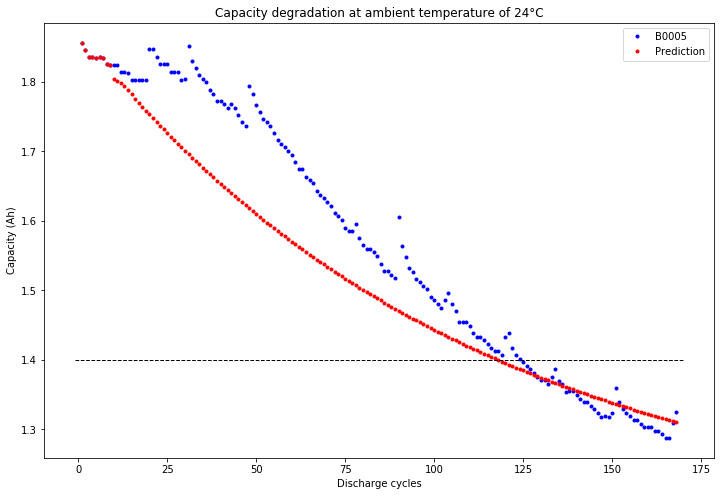

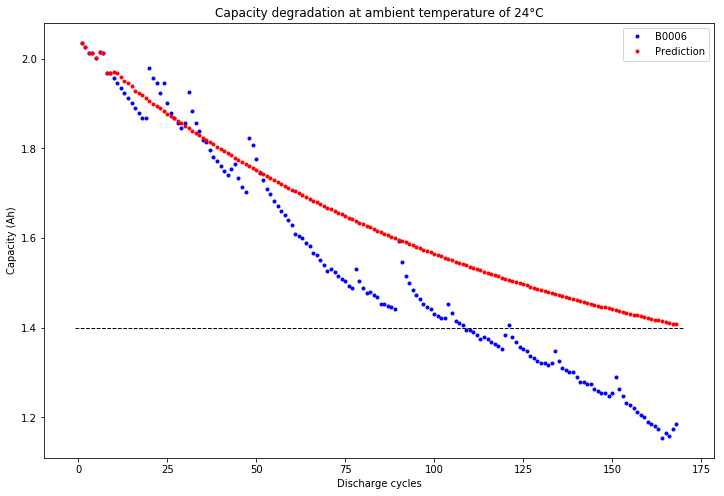

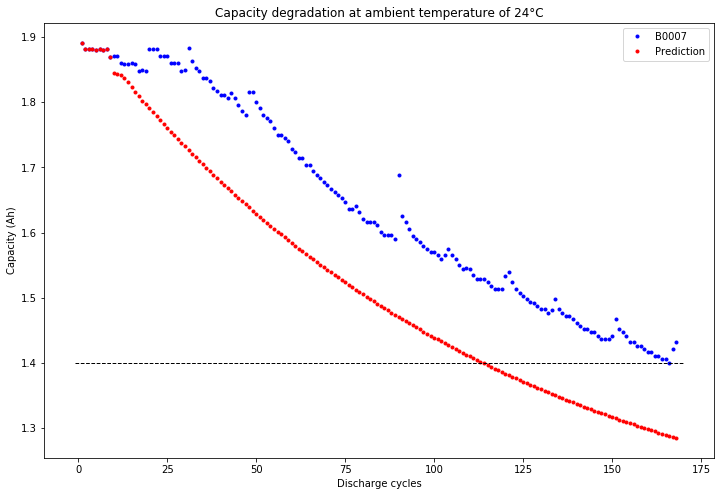

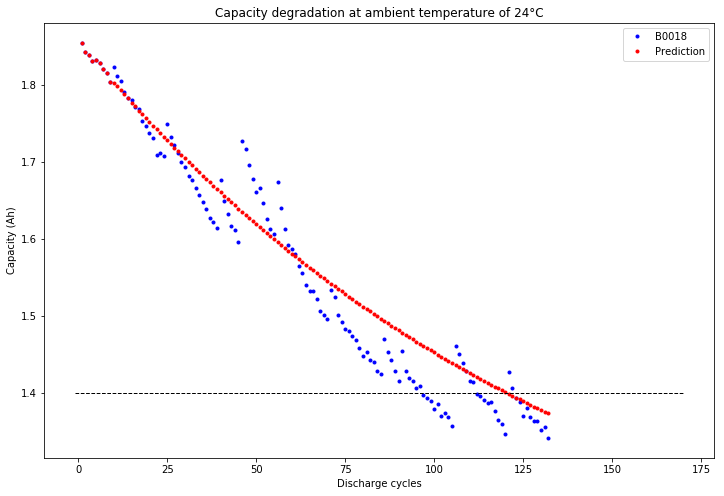

In [9]:
seed = 0
_, _, _, result_list = tain(LR=LR, feature_size=feature_size, hidden_size=hidden_size, 
                            weight_decay=weight_decay,window_size=window_size, EPOCH=EPOCH, seed=seed)
for i in range(4):
    name = Battery_list[i]
    train_x, train_y, train_data, test_data = get_train_test(Battery, name, window_size)

    aa = train_data[:window_size+1].copy() # 第一个输入序列
    [aa.append(a) for a in result_list[i]] # 测试集预测结果

    battery = Battery[name]
    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.plot(battery[0], battery[1], 'b.', label=name)
    ax.plot(battery[0], aa, 'r.', label='Prediction')
    plt.plot([-1,170],[Rated_Capacity*0.7, Rated_Capacity*0.7], c='black', lw=1, ls='--')  # 临界点直线
    ax.set(xlabel='Discharge cycles', ylabel='Capacity (Ah)', title='Capacity degradation at ambient temperature of 24°C')
    plt.legend()